### Model Comparison
Comparing models is something data scientists do all the time. There's very rarely just one model that would be possible to run for a given situation, so learning to choose the best one is very important.

Here let's work on regression. Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsRegressor

from sklearn import linear_model

# Suppress annoying harmless error.

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from matplotlib.mlab import PCA as mlabPCA
from sklearn.decomposition import PCA 

In [3]:
link = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'

indices_to_skip = np.array([0,1,2,353,354,355])

df = pd.read_csv(link,skiprows=indices_to_skip , header=1)

df.tail()


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
343,Woodbury Town,"10,685",3,0,NaN,0,2,1,541,9,529,3,NaN
344,Woodridge Village,829,7,0,NaN,0,0,7,17,8,9,0,0.0
345,Woodstock Town,"5,931",2,0,NaN,0,0,2,58,13,45,0,NaN
346,Yonkers,"199,134","1,036",6,NaN,25,390,615,"2,368",470,"1,662",236,10.0
347,Yorktown Town,"36,643",15,0,NaN,0,2,13,334,45,287,2,NaN


In [4]:
df.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [5]:
df.shape

(348, 13)

In [6]:
df.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

### Replace ',' before converting to numeric:

In [11]:
cols = df.columns.drop(['City','Murder and\nnonnegligent\nmanslaughter','Rape\n(revised\ndefinition)1','Arson3'])

# Replace ',' before converting to numeric:
df[cols]=df[cols].replace(',*','',regex=True)

# Convert to numeric
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [12]:
df.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,3.480000e+02,348.000000,348.000000,0.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,187.000000
mean,4.003763e+04,201.594828,1.566092,NaN,5.864943,72.902299,121.261494,792.606322,119.683908,637.017241,35.905172,1.871658
std,4.500374e+05,2815.268504,18.303673,NaN,60.425452,1031.032873,1706.131730,7659.724746,924.948789,6346.054451,403.423826,10.693411
min,5.260000e+02,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.003000e+03,2.000000,0.000000,NaN,0.000000,0.000000,1.000000,40.500000,6.000000,31.000000,0.000000,0.000000
50%,7.233500e+03,6.000000,0.000000,NaN,0.000000,1.000000,4.000000,112.500000,17.500000,94.000000,2.000000,0.000000
75%,1.842750e+04,22.000000,0.000000,NaN,2.000000,5.000000,14.000000,341.000000,51.250000,287.250000,7.000000,1.000000
max,8.396126e+06,52384.000000,335.000000,NaN,1112.000000,19170.000000,31767.000000,141971.000000,16606.000000,117931.000000,7434.000000,132.000000


### >>> std in `Population` is huge, this is an outlier that kills the analysis!

Drop values in "Population" that are outliers (more than 3 stdev from the mean):

In [13]:
q = df["Population"].quantile(0.99)
df2=df[df["Population"] < q].sort_values('Population', ascending=False)

In [14]:
df2.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,344.000000,344.000000,344.000000,0.0,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,185.000000
mean,14152.572674,33.078488,0.334302,NaN,1.938953,10.377907,20.427326,316.703488,53.863372,253.366279,9.473837,1.124324
std,18876.820762,105.875978,1.559842,NaN,5.662448,36.303823,64.048728,602.880988,134.720665,454.846951,28.850664,4.758368
min,526.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2983.250000,2.000000,0.000000,NaN,0.000000,0.000000,1.000000,39.000000,6.000000,31.000000,0.000000,0.000000
50%,7106.000000,6.000000,0.000000,NaN,0.000000,1.000000,4.000000,111.500000,17.000000,93.500000,2.000000,0.000000
75%,17889.250000,21.000000,0.000000,NaN,2.000000,5.000000,13.250000,334.750000,50.000000,275.500000,7.000000,1.000000
max,143834.000000,1192.000000,21.000000,NaN,75.000000,400.000000,696.000000,6473.000000,1781.000000,4298.000000,394.000000,57.000000


In [15]:
df2['Robbery'].value_counts()#.head(10)

0      139
1       56
2       25
3       23
4       14
5       10
16       7
6        6
13       5
11       5
8        5
12       4
9        3
10       3
7        3
17       2
19       2
31       2
26       2
23       1
15       1
20       1
21       1
22       1
400      1
24       1
228      1
227      1
204      1
203      1
166      1
150      1
145      1
102      1
101      1
100      1
81       1
76       1
60       1
51       1
48       1
47       1
39       1
34       1
29       1
28       1
25       1
Name: Robbery, dtype: int64

From `robbery` we noticed that there are many low values and only a few cities with higher values. We can level off these values to 1 or 0. If there are 3 robberies we can reduce it to zero as it is not so relevant.
### Create a new column from `Robbery` that has binary data based on condition:

In [16]:
df2['Robbery2'] = np.where(df2['Robbery']>5, 1, 0)

# Check to make sure it worked.
print(df2['Robbery'].groupby(df2['Robbery2']).describe())

          count       mean        std  min   25%   50%   75%    max
Robbery2                                                           
0         267.0   1.052434   1.426476  0.0   0.0   0.0   2.0    5.0
1          77.0  42.714286  67.647277  6.0  10.0  16.0  31.0  400.0


### Do the same with 'Murder and\nnonnegligent\nmanslaughter' which has fewer values and rename that column:

In [20]:
df2['Murder and\nnonnegligent\nmanslaughter'].value_counts()

0     299
1      31
2       4
8       2
7       2
3       2
21      1
10      1
5       1
4       1
Name: Murder and\nnonnegligent\nmanslaughter, dtype: int64

In [17]:
df2.loc[df['Murder and\nnonnegligent\nmanslaughter']>0,'Murder']=1
df2.loc[df['Murder and\nnonnegligent\nmanslaughter']==0,'Murder']=0

In [27]:
df2['Rape\n(legacy\ndefinition)2'].value_counts()

0     204
1      46
2      25
3      23
4      11
5       7
6       5
9       4
7       3
19      2
12      2
8       2
75      1
31      1
13      1
14      1
16      1
20      1
21      1
27      1
30      1
11      1
Name: Rape\n(legacy\ndefinition)2, dtype: int64

In [28]:
df2.loc[df['Rape\n(legacy\ndefinition)2']>0,'Rape2']=1
df2.loc[df['Rape\n(legacy\ndefinition)2']==0,'Rape2']=0

In [29]:
df2.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3', 'Robbery2',
       'Murder', 'Rape2'],
      dtype='object')

In [33]:
df2=df2.drop(['City',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
        'Robbery',
       'Motor\nvehicle\ntheft', 'Arson3'],axis=1)

In [34]:
df2.describe()

,Population,Violent crime,Aggravated assault,Property crime,Burglary,Larceny- theft,Robbery2,Murder,Rape2
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,14152.572674,33.078488,20.427326,316.703488,53.863372,253.366279,0.223837,0.130814,0.406977
std,18876.820762,105.875978,64.048728,602.880988,134.720665,454.846951,0.417421,0.337688,0.491986
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2983.250000,2.000000,1.000000,39.000000,6.000000,31.000000,0.000000,0.000000,0.000000
50%,7106.000000,6.000000,4.000000,111.500000,17.000000,93.500000,0.000000,0.000000,0.000000
75%,17889.250000,21.000000,13.250000,334.750000,50.000000,275.500000,0.000000,0.000000,1.000000
max,143834.000000,1192.000000,696.000000,6473.000000,1781.000000,4298.000000,1.000000,1.000000,1.000000


In [35]:
df2.dtypes

Population               int64
Violent\ncrime           int64
Aggravated\nassault      int64
Property\ncrime          int64
Burglary                 int64
Larceny-\ntheft          int64
Robbery2                 int32
Murder                 float64
Rape2                  float64
dtype: object

### The two categorical columns, Robbery2,Rape2 and Murder, can be transformed into numeric representations with `getdummies`

In [37]:
# Making dummies.
# Also creating a data frame to hold our features.
features1 = pd.get_dummies(df2['Murder'])
features1.columns=['Murder_False','Murder_True']

features2 = pd.get_dummies(df2['Robbery2'])
features2.columns=['Robbery_False','Robbery_True']

features3 = pd.get_dummies(df2['Rape2'])
features3.columns=['Rape2_False','Rape2_True']


features = pd.concat((features1 , features2,features3),axis=1)
features.head()

,Murder_False,Murder_True,Robbery_False,Robbery_True,Rape2_False,Rape2_True
310,0,1,0,1,0,1
7,0,1,0,1,0,1
3,0,1,0,1,0,1
126,1,0,0,1,0,1
267,0,1,0,1,0,1


In [41]:
# Check summary:
print(features['Murder_False'].groupby(features['Murder_False']).describe())
print(features['Robbery_False'].groupby(features['Robbery_False']).describe())
print(features['Rape2_False'].groupby(features['Rape2_False']).describe())


              count  mean  std  min  25%  50%  75%  max
Murder_False                                           
0              45.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1             299.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
               count  mean  std  min  25%  50%  75%  max
Robbery_False                                           
0               77.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1              267.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0
             count  mean  std  min  25%  50%  75%  max
Rape2_False                                           
0            140.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1            204.0   1.0  0.0  1.0  1.0  1.0  1.0  1.0


In [45]:
prop_crime =  pd.concat((df2 , features),axis=1)

# Drop 3 categorical columns: 'Murder','Robbery2' and 'Rape2':
prop_crime = prop_crime.drop(['Murder','Robbery2','Rape2'],axis=1)

In [47]:
prop_crime.head()

,Population,Violent crime,Aggravated assault,Property crime,Burglary,Larceny- theft,Murder_False,Murder_True,Robbery_False,Robbery_True,Rape2_False,Rape2_True
310,143834,1192,696,6473,1781,4298,0,1,0,1,0,1
7,118296,107,68,2118,204,1882,0,1,0,1,0,1
3,97956,791,526,4090,705,3243,0,1,0,1,0,1
126,96667,151,82,2303,332,1925,1,0,0,1,0,1
267,87204,57,41,567,88,466,0,1,0,1,0,1


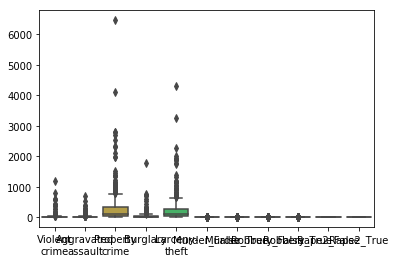

In [66]:
import seaborn as sns
sns.boxplot( data = prop_crime.drop(['Population'], axis=1 ))
plt.show()

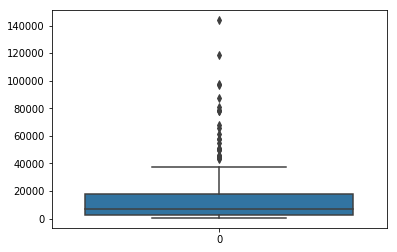

In [67]:
sns.boxplot( data = prop_crime['Population'])
plt.show()

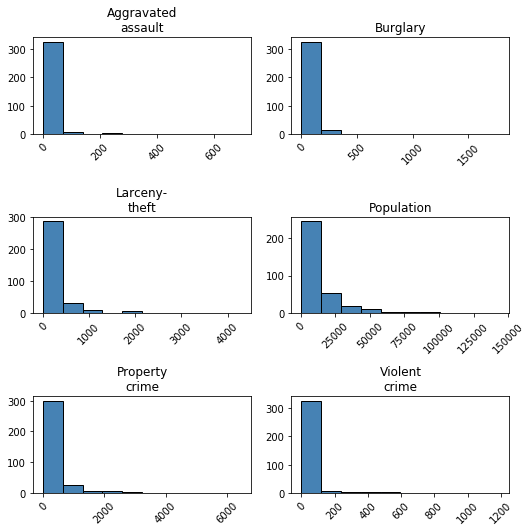

In [69]:
# Plot histograms to see what kind of distribution there is in each column:

fig = prop_crime.drop(['Murder_False','Murder_True','Robbery_False','Robbery_True','Rape2_False','Rape2_True']
                      ,axis=1).hist(bins=10,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(5,5),
                 grid=False)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))  

All of the histograms are skewed to the right. There are a lot of small values and a few big ones. It seems that the bigger the city, the bigger property crimes. We also have a small number of big cities. In a future analysis we should compare big cities between them.

In [73]:
prop_crime.sort_values( by= 'Population', ascending=False ).head()

,Population,Violent crime,Aggravated assault,Property crime,Burglary,Larceny- theft,Murder_False,Murder_True,Robbery_False,Robbery_True,Rape2_False,Rape2_True
310,143834,1192,696,6473,1781,4298,0,1,0,1,0,1
7,118296,107,68,2118,204,1882,0,1,0,1,0,1
3,97956,791,526,4090,705,3243,0,1,0,1,0,1
126,96667,151,82,2303,332,1925,1,0,0,1,0,1
267,87204,57,41,567,88,466,0,1,0,1,0,1


### How much correlation is between the data:

                     Population  Violent\ncrime  Aggravated\nassault  \
Population             1.000000        0.687220             0.676598   
Violent\ncrime         0.687220        1.000000             0.995721   
Aggravated\nassault    0.676598        0.995721             1.000000   
Property\ncrime        0.864014        0.868978             0.866891   
Burglary               0.732518        0.932024             0.926448   
Larceny-\ntheft        0.881787        0.816051             0.816099   
Murder_False          -0.498124       -0.494685            -0.487664   
Murder_True            0.498124        0.494685             0.487664   
Robbery_False         -0.653992       -0.469162            -0.454853   
Robbery_True           0.653992        0.469162             0.454853   
Rape2_False           -0.454019       -0.322556            -0.319955   
Rape2_True             0.454019        0.322556             0.319955   

                     Property\ncrime  Burglary  Larceny-\ntheft

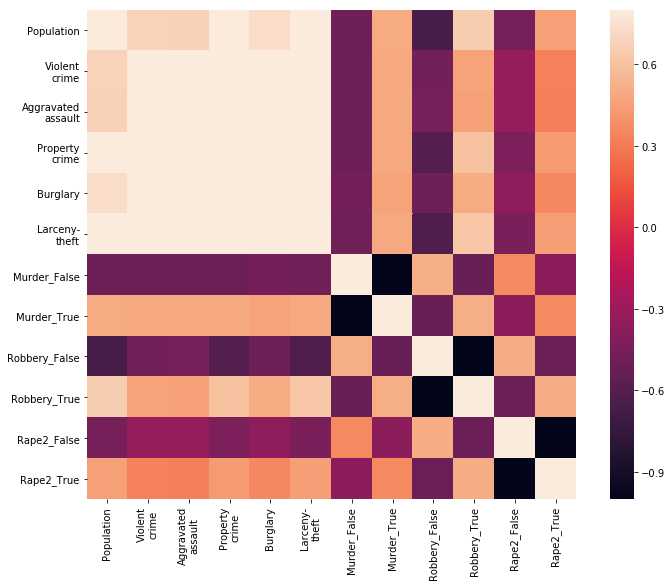

In [160]:
corrmat = prop_crime.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

There is a high correlation among the continous values.

## We will try to predict the `PROPERTY CRIME`

In [ ]:

KNN regression
# Prepare the data:
X = prop_crime.drop(['Property\ncrime'] , axis=1 )
y = prop_crime['Property\ncrime']

---------------------


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
---------------------
from scipy.stats import zscore

X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

---------------------

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10 , weights='distance' )
---------------------
# fitting the model
knn.fit(X_train, y_train)

# predict the response
y_pred =  knn.predict(X_test)
---------------------
y_pred[0:5]
---------------------
## The line / model
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
---------------------
CROSS VALIDATION:
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X_train , y_train , cv=10)
---------------------
score_w = cross_val_score(knn, X_train, y_train , cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))
---------------------


### KNN regression


In [48]:
# Prepare the data:
X = prop_crime.drop(['Property\ncrime'] , axis=1 )
y = prop_crime['Property\ncrime']


We can use the train_test_split function in order to make the split. 

The <b>test_size=0.2</b> inside the function indicates the percentage of the data that should be held over for testing. It’s usually around 80/20 or 70/30:

In [49]:

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(275, 11) (275,)
(69, 11) (69,)


** Feature Scaling**

Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.



In [11]:
#scaler = StandardScaler()  
#scaler.fit(X_train)
#
#X_train = scaler.transform(X_train)  
#X_test = scaler.transform(X_test)  


#### OR:

In [50]:
from scipy.stats import zscore

X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

In [ ]:
# Note that `select_dtypes` returns a data frame. We are selecting only the columns
#numeric_cols = df.select_dtypes(include=[np.number]).columns
#df[numeric_cols].apply(zscore)

### Build our model.
* with `weigths`

In [87]:
# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10 , weights='distance' )

In [88]:
# fitting the model
knn.fit(X_train, y_train)

# predict the response
y_pred =  knn.predict(X_test)


In [89]:
y_pred[0:5]

array([526.04184255, 111.3200135 , 301.81552155, 677.81906763,
       113.60846537])

Text(0,0.5,'Predictions')

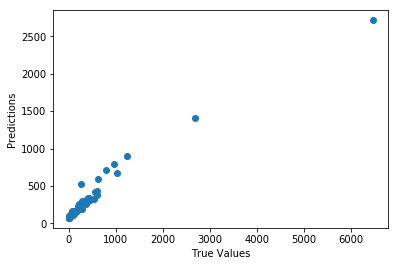

In [90]:
## The line / model
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

** Hold Out validation: **

In [91]:
print('With 20% Holdout: ' + str(knn.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(knn.fit(X, y).score(X, y)))

With 20% Holdout: 0.6613193913723834
Testing on Sample: 1.0


**Cross Validation:**

In [92]:
from sklearn.model_selection import cross_val_score
cross_val_score(knn, X_train , y_train , cv=10)

array([0.86935796, 0.93755418, 0.87520756, 0.83708417, 0.75342296,
       0.85200519, 0.93972972, 0.88554321, 0.79956892, 0.99221631])

In [93]:
score_w = cross_val_score(knn, X_train, y_train , cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Weighted Accuracy: 0.87 (+/- 0.13)


### What is the optimal number of $k$'s?

In [75]:
# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors_ = list(filter(lambda x: x % 2 != 0, myList))



In [76]:
# loading library
from sklearn.neighbors import KNeighborsRegressor

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors_:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10  
                             #, scoring='accuracy'  
                            )
    cv_scores.append(scores.mean())

In [79]:
cv_scores[0:5]

[0.9031102793495067,
 0.8893161396982642,
 0.8762318275439286,
 0.8650384279464671,
 0.8487024871041324]

The optimal number of neighbors is 1


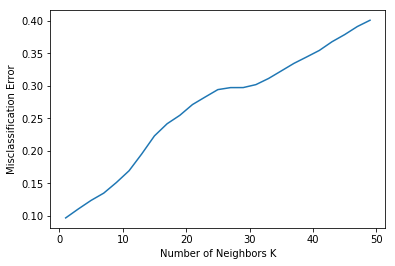

In [80]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors_[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors_, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

### Linear regression:

In [101]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
X_ols = prop_crime.drop(['Property\ncrime'] , axis=1 )#.values.reshape(-1, 1)
y_ols = prop_crime['Property\ncrime']
regr.fit(X_ols, y_ols)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_ols, y_ols ))


Coefficients: 
 [ 2.12136111e-04  5.69703298e-01 -7.01602917e-01  1.08836610e+00
  9.98220329e-01  2.50758323e+00 -2.50758323e+00  1.30382232e+00
 -1.30382232e+00  8.26309486e-01 -8.26309486e-01]

Intercept: 
 -5.07567032740576

R-squared:
0.999872576556937


### Assumption two: multivariate normality

The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed. Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

Outliers or skewness in error can often be traced back to outliers or skewness in data.


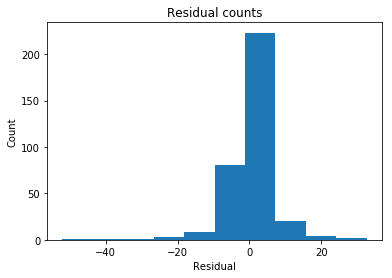

In [102]:
# Extract predicted values.
predicted = regr.predict(X_ols).ravel()
actual = prop_crime['Property\ncrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Assumption three: homoscedasticity

The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance. This leads to overconfidence in the accuracy of your model's predictions.

Some fixes to heteroscedasticity include transforming the dependent variable and adding features that target the poorly-estimated areas. For example, if a model tracks data over time and model error variance jumps in the September to November period, a binary feature indicating season may be enough to resolve the problem.


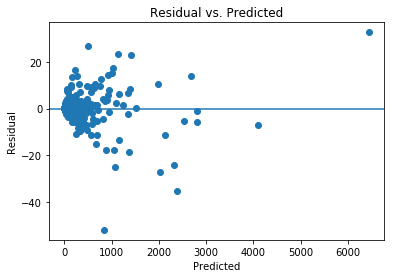

In [103]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

### Assumption one: linear relationship

As mentioned earlier, features in a regression need to have a linear relationship with the outcome. If the relationship is non-linear, the regression model will try to find any hint of a linear relationship, and only explain that – with predictable consequences for the validity of the model.

Sometimes this can be fixed by applying a non-linear transformation function to a feature. For example, if the relationship between feature and outcome is quadratic and all feature scores are > 0, we can take the square root of the features, resulting in a linear relationship between the outcome and sqrt(feature). 

In [104]:
prop_crime.dtypes

Population             int64
Violent\ncrime         int64
Aggravated\nassault    int64
Property\ncrime        int64
Burglary               int64
Larceny-\ntheft        int64
Murder_False           uint8
Murder_True            uint8
Robbery_False          uint8
Robbery_True           uint8
Rape2_False            uint8
Rape2_True             uint8
dtype: object

In [105]:
prop_crime.describe()

,Population,Violent crime,Aggravated assault,Property crime,Burglary,Larceny- theft,Murder_False,Murder_True,Robbery_False,Robbery_True,Rape2_False,Rape2_True
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,14152.572674,33.078488,20.427326,316.703488,53.863372,253.366279,0.869186,0.130814,0.776163,0.223837,0.593023,0.406977
std,18876.820762,105.875978,64.048728,602.880988,134.720665,454.846951,0.337688,0.337688,0.417421,0.417421,0.491986,0.491986
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2983.250000,2.000000,1.000000,39.000000,6.000000,31.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,7106.000000,6.000000,4.000000,111.500000,17.000000,93.500000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,17889.250000,21.000000,13.250000,334.750000,50.000000,275.500000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,143834.000000,1192.000000,696.000000,6473.000000,1781.000000,4298.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


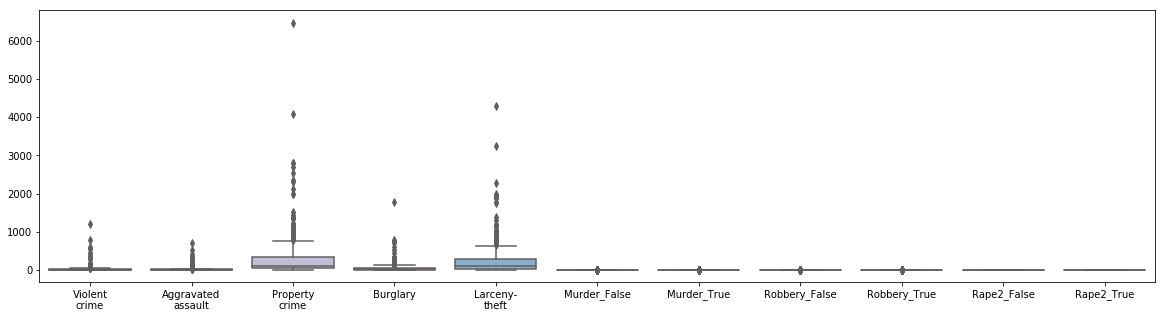

In [107]:
import seaborn as sns
plt.figure(figsize=(20,5))
sns.boxplot(data = prop_crime.drop(['Population'],axis=1) , palette="Set3"   )
plt.show()

It seems there are many outliers for each feature. We have already dropped the biggest outliers.

### Create the default pairplot for numerical columns to better see how data is groupping:

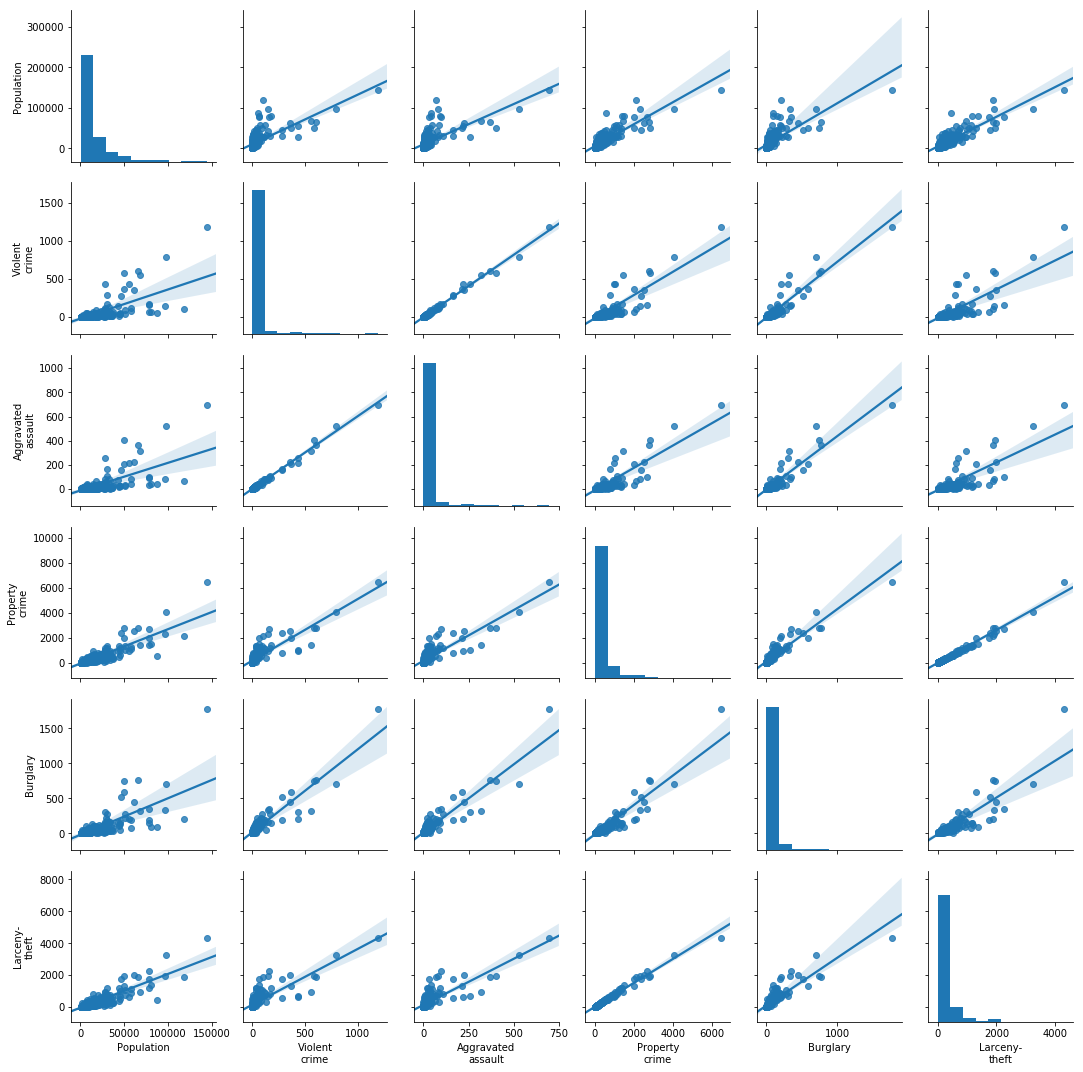

In [112]:
g=sns.pairplot(prop_crime.drop(['Murder_False','Murder_True','Robbery_False','Robbery_True','Rape2_False','Rape2_True']
                      ,axis=1).fillna(0) , diag_kind='hist' , kind='reg' )
plt.show()

### Logarithm:

Log of a variable is a common transformation method used to change the shape of distribution of the variable on a distribution plot. It is generally used for reducing right skewness of variables. Though, It can’t be applied to zero or negative values as well.


In [113]:
prop_crime.drop(['Murder_False','Murder_True','Robbery_False','Robbery_True','Rape2_False','Rape2_True']
                      ,axis=1).columns

Index(['Population', 'Violent\ncrime', 'Aggravated\nassault',
       'Property\ncrime', 'Burglary', 'Larceny-\ntheft'],
      dtype='object')

In [114]:
# Display if there are any below zero values:
prop_crime[(prop_crime < 0).any(axis=1)]

,Population,Violent crime,Aggravated assault,Property crime,Burglary,Larceny- theft,Murder_False,Murder_True,Robbery_False,Robbery_True,Rape2_False,Rape2_True


### Apply transformation to 3 columns that seem to not have a normal distribution:

In [115]:
prop_crime_log = prop_crime.drop(['Murder_False','Murder_True','Robbery_False','Robbery_True','Rape2_False','Rape2_True']
                      ,axis=1
                               ).apply(np.log)

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
C:\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1728: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


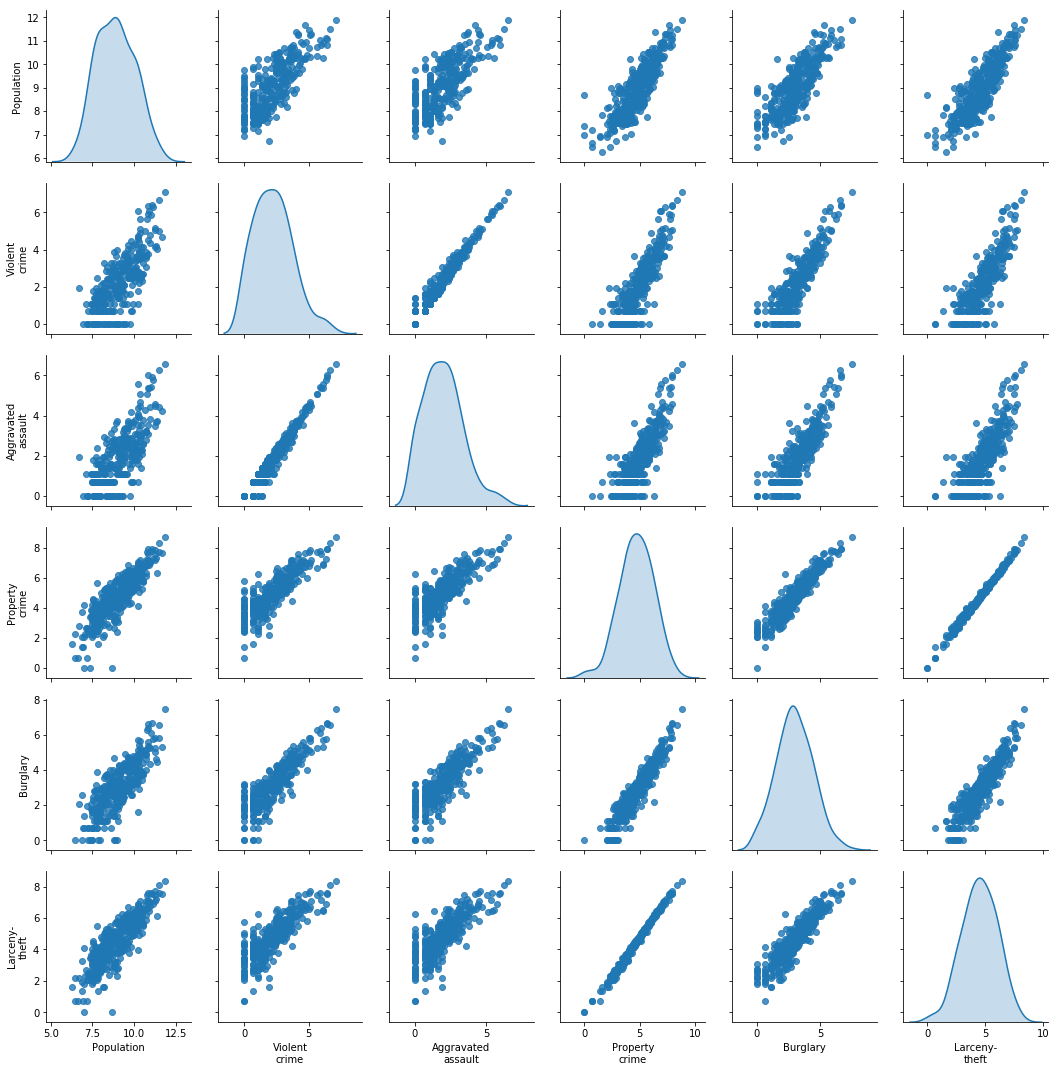

In [116]:
g=sns.pairplot(prop_crime_log, diag_kind='kde' , kind='reg'
               #, plot_kws=dict(edgecolor="k", linewidth=0.5)
               , diag_kws=dict(shade=True)
              )
plt.show()

In [117]:
prop_crime_log

,Population,Violent crime,Aggravated assault,Property crime,Burglary,Larceny- theft
310,11.876415,7.083388,6.545350,8.775395,7.484930,8.365905
7,11.680945,4.672829,4.219508,7.658228,5.318120,7.540090
3,11.492274,6.673298,6.265301,8.316300,6.558198,8.084254
126,11.479027,5.017280,4.406719,7.741968,5.805135,7.562681
267,11.376005,4.043051,3.713572,6.340359,4.477337,6.144186
57,11.298556,4.174387,3.688879,7.323171,4.595120,7.235619
214,11.274668,5.164786,4.488636,7.237778,5.010635,7.066467
53,11.269082,5.062595,4.595120,7.896925,5.843544,7.727976
62,11.267217,4.143135,3.465736,7.595890,5.225747,7.469084
206,11.128307,6.317165,5.758902,7.269617,5.758902,6.879356


In [172]:
# Instantiate and fit our model.
# Replace '-inf' with 'nan' and 'nan' with zero:
regr_tran = linear_model.LinearRegression()
X_ols = prop_crime_log.drop(['Property\ncrime'],axis=1).replace([np.inf, -np.inf], np.nan).fillna(0)
y_ols = prop_crime['Property\ncrime']#.replace([np.inf, -np.inf], np.nan).fillna(0).values.reshape(-1, 1)

regr_tran.fit(X_ols, y_ols)

# Inspect the results.
print('\nCoefficients: \n', regr_tran.coef_)
print('\nIntercept: \n', regr_tran.intercept_)
print('\nR-squared:')
print(regr_tran.score(X_ols, y_ols ))


Coefficients: 
 [ 89.4458054  -25.3825153  203.75845739  51.08994371  14.35125834]

Intercept: 
 -970.4573396710089

R-squared:
0.528888614602234


### What is Principal Components Analysis (PCA)?
PCA is a complexity-reduction technique that tries to reduce a set of variables down to a smaller set of components that represent most of the information in the variables. At a conceptual level, PCA works by identifying sets of variables that share variance, and creating a component to represent that variance.

### PCA works best for normally-distributed data 
PCA works best for normally-distributed data and assumes the relationships among variables are linear. 

PCA also works best when the variables involved range from weakly correlated to moderately strongly correlated. Correlations of 0, or correlations greater than .7 or .8, create problems. Correlations near 0 mean there is no shared information. 

### Correlations that are too high can result in components that are unstable 
and change a lot in response to very small changes in the data, or components that are made up of variance from only one or two variables. 
* <i>A few very high or very low correlations are fine.</i>

### Eigenvalues
Eigenvalues represent the length of the Eigenvectors – each eigenvector has an eigenvalue. 

>The length of the eigenvector encodes the proportion of total variance explained by a component. 

The total variance is equal to the number of variables in the PCA. Thus, an Eigenvalue of 1 means that the component explains the same amount of variance as one variable. An eigenvalue greater than 1 is desirable, since a component with an eigenvalue of 1 adds no value beyond the information contained in any individual variable, and an eigenvalue of less than 1 is actually less efficient at conveying information than a variable by itself. An eigenvalue of 2 means that the component contains an amount of information equal to that of two variables. Of course, it doesn’t mean that only two variables load on that component.

In [129]:
# Take a subset of the data for PCA and drop missing values because PCA cannot
# handle them. We could also impute, but missingness is quite low so dropping
# missing rows is unlikely to create bias.
df_pca = prop_crime.drop(['Property\ncrime' ], axis=1)

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X_pca = StandardScaler().fit_transform(df_pca)

In [134]:
sklearn_pca = PCA(n_components = len(df_pca.columns) )
Y_sklearn = sklearn_pca.fit_transform(X_pca)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    np.round(sklearn_pca.explained_variance_ratio_,3)
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.608 0.153 0.109 0.082 0.033 0.01  0.005 0.    0.    0.    0.   ]


### The first 3 components explain 87%(=61+15+11) of the variation of the initial features!

Below we'll see which one should be kept or not.

In [135]:
# What are the numbers of the eigenvalues?
pca = PCA()
eigenvalues = sklearn_pca.explained_variance_
eigenvalues

array([6.71240462e+00, 1.68404672e+00, 1.20397408e+00, 9.02131880e-01,
       3.64387605e-01, 1.09121167e-01, 5.23851477e-02, 3.61875740e-03,
       5.05190030e-32, 2.24987785e-32, 9.40647900e-33])

Upon visual inspection, the analyst will keep all the components whose eigenvalue falls above the point where the slope of the line changes the most drastically, also called the "elbow":

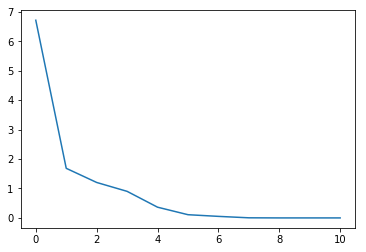

In [136]:
plt.plot(eigenvalues)
plt.show()

* We should keep the first 3 components because they are greater than 1 and both are where the elbow has the slope with the biggest dramatic change. 

In [221]:
principalDf = pd.DataFrame(data = Y_sklearn[:,0:3]
             , columns = ['principal_component_1', 'principal_component_2','principal_component_3'])
principalDf#.head()

,principal_component_1,principal_component_2,principal_component_3
0,19.693899,11.488816,4.108164
1,7.033386,-0.548467,-1.044295
2,13.355427,5.992658,1.463562
3,5.574381,0.403527,2.629377
4,4.835542,-1.841025,-1.982030
5,3.837635,-0.961253,1.899934
6,4.350131,-0.289852,2.070165
7,5.656495,0.623093,2.708415
8,3.254767,1.315629,0.872811
9,8.367411,2.055122,-0.625560


Before concatenating with 'Property crime' we should reset the index for the data to remain in the correct order. Otherwise b/c the concat is performed by matching the index, 'Property crime' would be shuffeled.

In [222]:
prop_crime3=prop_crime['Property\ncrime'].reset_index(drop=True)

In [223]:
principalDf = pd.concat((principalDf , prop_crime3),axis=1)

In [224]:
prop_crime['Property\ncrime'].head()

310    6473
7      2118
3      4090
126    2303
267     567
Name: Property\ncrime, dtype: int64

In [186]:
principalDf.head()

,principal_component_1,principal_component_2,principal_component_3,Property crime
0,19.693899,11.488816,4.108164,6473
1,7.033386,-0.548467,-1.044295,2118
2,13.355427,5.992658,1.463562,4090
3,5.574381,0.403527,2.629377,2303
4,4.835542,-1.841025,-1.982030,567


In [187]:
X_pca_col = principalDf.columns.drop(['Property\ncrime' ])
X_pca_col

Index(['principal_component_1', 'principal_component_2',
       'principal_component_3'],
      dtype='object')

In [188]:
principalDf = principalDf.fillna(0)

Y_pca2 = principalDf['Property\ncrime'].values.reshape(-1, 1)
X_pca2 = principalDf[X_pca_col]

In [189]:
# Instantiate and fit our model using the initial y_ols.
regr2 = linear_model.LinearRegression()

regr2.fit(X_pca2, Y_pca2)

# Inspect the results.
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X_pca2, Y_pca2))


Coefficients: 
 [[210.67506598 137.23050656 102.61735579]]

Intercept: 
 [316.70348837]

R-squared:
0.941811058691623


In [173]:
#y_ols

### The result is a bit lower than the initial one, which had more concern of overfitting.

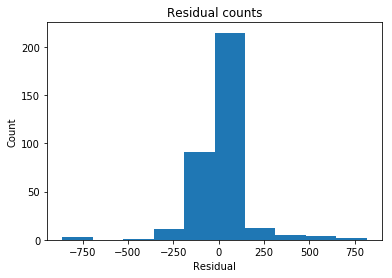

In [174]:
# Extract predicted values.
predicted = regr2.predict(X_pca2).ravel()
actual = prop_crime['Property\ncrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

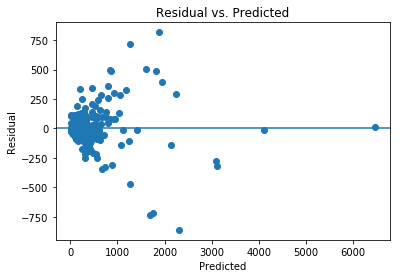

In [175]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# ?

## Evaluating Linear regression models

In [194]:
principalDf['Property_crime'] = principalDf['Property\ncrime']

In [195]:
principalDf.columns

Index(['principal_component_1', 'principal_component_2',
       'principal_component_3', 'Property\ncrime', 'Property_crime'],
      dtype='object')

In [180]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [196]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
#linear_formula = '\'Property\ncrime\' ~ \'principal component 1\'+ \'principal component 2\'+  \'principal component 3\''
linear_formula = 'Property_crime ~ principal_component_1+ principal_component_2+  principal_component_3'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=principalDf).fit()

Let's look at the coefficients of our model.

In [197]:
lm.params

Intercept                316.703488
principal_component_1    210.675066
principal_component_2    137.230507
principal_component_3    102.617356
dtype: float64

And at the p-values as a significance test for each of the coefficients.

In [198]:
lm.pvalues

Intercept                2.838389e-131
principal_component_1    1.954380e-202
principal_component_2     1.289465e-69
principal_component_3     1.485059e-36
dtype: float64

Finally, here's our $R^2$:

In [199]:
lm.rsquared

0.941811058691623

## Dimensionality Reduction in Linear Regression

In [230]:
from sklearn.cross_decomposition import PLSRegression

X_pca_col = prop_crime.columns.drop(['Property\ncrime' ])
X_pca_col

Y_pca2 = prop_crime['Property\ncrime'].values.reshape(-1, 1)
X_pca2 = prop_crime[X_pca_col]

R-squared regression: 0.999872576556937
R-squared PLSR: 0.9772827032888864


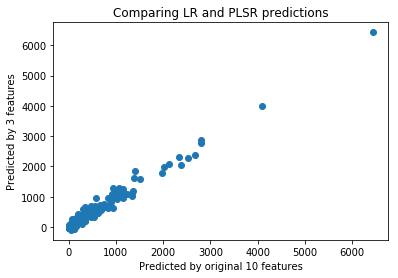

In [231]:
# Fit a linear model with all 10 features.
regr3 = linear_model.LinearRegression()
regr3.fit(X_pca2, Y_pca2)

# Save predicted values.
Y_pred = regr3.predict(X_pca2)
print('R-squared regression:', regr3.score(X_pca2, Y_pca2))

# Fit a linear model using Partial Least Squares Regression.
# Reduce feature space to 3 dimensions.
pls1 = PLSRegression(n_components=3)

# Reduce X to R(X) and regress on y.
pls1.fit(X_pca2, Y_pca2)

# Save predicted values.
Y_PLS_pred = pls1.predict(X_pca2)
print('R-squared PLSR:', pls1.score(X_pca2, Y_pca2))

# Compare the predictions of the two models
plt.scatter(Y_pred,Y_PLS_pred) 
plt.xlabel('Predicted by original 10 features')
plt.ylabel('Predicted by 3 features')
plt.title('Comparing LR and PLSR predictions')
plt.show()

## KNN regression after PCA:

In [ ]:
X_pca_col = principalDf.columns.drop(['Property\ncrime' ])
X_pca_col

In [ ]:
Y_pca2 = principalDf['Property\ncrime'].values.reshape(-1, 1)
X_pca2 = 

In [162]:

# Prepare the data:
X = principalDf[X_pca_col]
y = principalDf['Property\ncrime'].values.reshape(-1, 1)

#---------------------


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#---------------------
from scipy.stats import zscore

X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

#---------------------

# Build our model.
knn_pca = neighbors.KNeighborsRegressor(n_neighbors=10 , weights='distance' )
#---------------------
# fitting the model
knn_pca.fit(X_train, y_train)

# predict the response
y_pred =  knn_pca.predict(X_test)
#---------------------





(275, 3) (275, 1)
(69, 3) (69, 1)


In [163]:
y_pred[0:5]
#---------------------

array([[4.25395993e+02],
       [6.59050411e+00],
       [4.74458827e+02],
       [8.96934995e+02],
       [6.99259459e-01]])

Text(0,0.5,'Predictions')

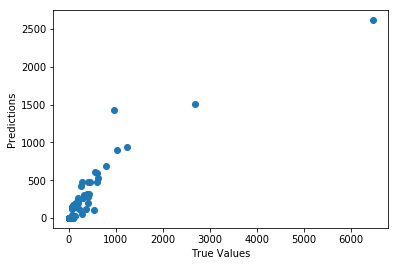

In [164]:
## The line / model
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [165]:
# CROSS VALIDATION:
from sklearn.model_selection import cross_val_score
cross_val_score(knn_pca, X_train , y_train , cv=10)



array([0.64348501, 0.94314462, 0.8467737 , 0.84925275, 0.75608594,
       0.71828424, 0.96939768, 0.9004064 , 0.73147003, 0.92906331])

In [167]:
score_w = cross_val_score(knn_pca, X_train, y_train , cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))


Weighted Accuracy: 0.83 (+/- 0.21)


### The Knn after PCA gives the same result as the KNN without it. 

Linear regression gives a higher percentage after PCA ?